In [1]:
## embed=65, wd=0.0001, structured_loss
import numpy as np
import pandas as pd
import fastai
from tqdm import tqdm_notebook as tqdm

from fastai.tabular import *
import fastai.text

import pickle

from multiprocessing import Pool
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler

import torch.nn as nn
import torch.nn.functional as F
from functools import partial


np.range = (lambda x:(x.min(), x.max()))
!ls ../input

champs-scalar-coupling	sc-train-features		 trainedmodel
sc-pre-features		sc-train-features-aug-structure
sc-structures-pre	tmpwts


In [2]:
with open('../input/sc-pre-features/train_test_pre.pkl', 'rb') as f:
    train, test, column_names = pickle.load(f)
    
with open('../input/sc-structures-pre/molecules.pkl', 'rb') as f:
    molecules_structure, structure_cols, atom_encoder = pickle.load(f)

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
!ls ../input/champs-scalar-coupling/

dipole_moments.csv		sample_submission.csv		   test.csv
magnetic_shielding_tensors.csv	scalar_coupling_contributions.csv  train.csv
mulliken_charges.csv		structures
potential_energy.csv		structures.csv


In [4]:
column_names

['id',
 'molecule_name',
 'atom_index_0',
 'atom_index_1',
 'type_i',
 'type_a',
 'type',
 'atom_2',
 'atom_3',
 'atom_4',
 'atom_5',
 'atom_6',
 'angle',
 'd_1_0',
 'd_2_0',
 'd_2_1',
 'd_3_0',
 'd_3_1',
 'd_3_2',
 'd_4_0',
 'd_4_1',
 'd_4_2',
 'd_4_3',
 'd_5_0',
 'd_5_1',
 'd_5_2',
 'd_5_3',
 'd_6_0',
 'd_6_1',
 'd_6_2',
 'd_6_3',
 'scalar_coupling_constant']

In [5]:
c = pd.read_csv('../input/champs-scalar-coupling/scalar_coupling_contributions.csv')

In [6]:
c.shape

(4658147, 8)

In [7]:
c.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013


In [8]:
c.describe()

,atom_index_0,atom_index_1,fc,sd,pso,dso
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,1.335689e+01,5.883966e+00,1.569776e+01,8.233637e-02,3.751619e-01,-2.336117e-01
std,3.267712e+00,4.993943e+00,3.441461e+01,1.386516e-01,7.422133e-01,9.296036e-01
min,0.000000e+00,0.000000e+00,-3.722400e+01,-3.184910e+00,-3.288110e+00,-6.856790e+00
25%,1.100000e+01,2.000000e+00,-2.129645e-01,-1.438100e-02,-3.506500e-02,-3.734250e-01
50%,1.300000e+01,5.000000e+00,2.327140e+00,5.072900e-02,1.594810e-01,-6.476600e-02
75%,1.600000e+01,8.000000e+00,7.472885e+00,1.303520e-01,4.350445e-01,1.433210e-01
max,2.800000e+01,2.800000e+01,2.055170e+02,2.296690e+00,8.201530e+00,1.701610e+00


In [9]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type_i,type_a,type,atom_2,atom_3,atom_4,...,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,scalar_coupling_constant
0,0,dsgdb9nsd_000001,2,1,0,0,0,1,1,1,...,-0.615493,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,84.807602
1,1,dsgdb9nsd_000001,2,3,1,1,3,2,1,1,...,-0.615493,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,-11.257000
2,2,dsgdb9nsd_000001,2,4,1,1,3,2,1,1,...,-0.615492,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,-11.254800
3,3,dsgdb9nsd_000001,2,5,1,1,3,2,1,1,...,-0.615478,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,-11.254300
4,4,dsgdb9nsd_000001,3,1,0,0,0,1,1,1,...,-0.615493,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,84.807404


In [10]:
train.shape

(4658147, 32)

In [11]:
# train = train[~(train.type==0)]
# train.shape

In [12]:
# train=train[:4096]
# test=test[:2048]

In [13]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type_i,type_a,type,atom_2,atom_3,atom_4,...,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,scalar_coupling_constant
0,0,dsgdb9nsd_000001,2,1,0,0,0,1,1,1,...,-0.615493,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,84.807602
1,1,dsgdb9nsd_000001,2,3,1,1,3,2,1,1,...,-0.615493,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,-11.257000
2,2,dsgdb9nsd_000001,2,4,1,1,3,2,1,1,...,-0.615492,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,-11.254800
3,3,dsgdb9nsd_000001,2,5,1,1,3,2,1,1,...,-0.615478,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,-11.254300
4,4,dsgdb9nsd_000001,3,1,0,0,0,1,1,1,...,-0.615493,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,84.807404


In [14]:
train.groupby('type').apply(lambda x: (len(x)/len(train)*100, np.range(x.scalar_coupling_constant)))

type
0    (15.229575193741201, (66.60079956054688, 204.8...
1    (0.9309066459259444, (24.322200775146484, 80.4...
2    (24.48772011703366, (-36.21860122680664, 42.81...
3    (8.115587593092274, (-35.17610168457031, 11.85...
4    (2.5600952481748642, (-2.620850086212158, 17.7...
5    (32.424459769088436, (-18.58209991455078, 76.0...
6    (12.679097503792816, (-3.0204598903656006, 17....
7    (3.572557929150798, (-3.172410011291504, 10.97...
dtype: object

In [15]:
for key in molecules_structure:
    molecules_structure[key] = (molecules_structure[key][0], molecules_structure[key][1].cuda())

In [16]:
class Dataset:
    def __init__(self, x, y=None):
        assert (y is None) or (len(x) == len(y))
        self.x, self.y = x, y
        
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            if self.y is not None: return Dataset(self.x[idx], self.y[idx])
            else: return Dataset(self.x[idx])
        else:
            if self.y is not None: return self.x[idx], self.y[idx]
            else: return self.x[idx]
            
    def __len__(self):
        return len(self.x)
    
    
class Sampler:
    def __init__(self, ds, bs=64, shuffle=True, drop_last=True):
        #print('sampler init, n: ', len(ds))
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        if drop_last: self.n = (self.n//self.bs)*self.bs

    def __iter__(self):
        for i in range(0, self.n, self.bs):
            yield self.idxs[i : min(self.n, i+self.bs)]

    def __len__(self):
        return (self.n-1)//self.bs + 1

    

def collate(batch):
    #print(batch)
    x, y = zip(*batch)
    x1, x2, x3 = zip(*x)
    x1, x2, x3, y = torch.stack(x1), torch.stack(x2), torch.stack(x3), torch.stack(y)
    return ((x1.cuda(), x2.cuda(), x3.cuda()), y.type(torch.DoubleTensor).cuda())



def tfrm_structure(mol, p, q, natoms):
    perm = np.arange(30)
    perm[1: natoms+1] = np.random.permutation(np.arange(1, natoms+1))
    p, = np.where(perm==p)[0]
    q, = np.where(perm==q)[0]
    mol = mol[perm]
    return mol, p, q



class Dataloader:
    def __init__(self, dataset, bs=256, shuffle=True, collate_fn=collate, tfrm=None, drop_last=True):
        self.dataset, self.bs, self.shuffle, self.collate_fn, self.tfrm = dataset, bs, shuffle, collate_fn, tfrm
        self.batch_size = self.bs
        self.drop_last = drop_last
        self.sampler = Sampler(self.dataset, self.bs, self.shuffle, drop_last)
        
    def _get(self, i):
        x, y = self.dataset[i]
        #print(x, y)
        mol = molecules_structure[x[0]][1]
        natoms = molecules_structure[x[0]][0]
        #if self.tfrm: mol = self.tfrm(mol)
            
        indices = tensor(x[1:3].astype(np.int64))
        meta = tensor(x[3:].astype(np.float32))
        
        return (indices, meta, mol), tensor(y)
        
    def __iter__(self):
        #print("new iterator")
        if self.shuffle: self.sampler = Sampler(self.dataset, self.bs, self.shuffle, self.drop_last)
        for idxs in self.sampler:
#             with Pool(4) as pool:
#                 batch = pool.map(self._get, idxs)
            batch = [self._get(i) for i in idxs]
            yield self.collate_fn(batch)
            
    def __len__(self):
        return self.sampler.__len__()

In [17]:
def collate_test(batch):
    x, y = zip(*batch)
    x1, x2, x3 = zip(*x)
    x1, x2, x3, y = torch.stack(x1), torch.stack(x2), torch.stack(x3), torch.stack(y)
    return ((x1.cuda(), x2.cuda(), x3.cuda()), y.type(torch.DoubleTensor).cuda())

class Dataloader_test:
    def __init__(self, dataset, bs=256, shuffle=False, collate_fn=collate_test, tfrm=None, drop_last=False):
        self.dataset, self.bs, self.shuffle, self.collate_fn, self.tfrm = dataset, bs, shuffle, collate_fn, tfrm
        self.batch_size = self.bs
        self.drop_last = drop_last
        self.sampler = Sampler(self.dataset, self.bs, self.shuffle, drop_last)
        
    def _get(self, i):
        x, y = self.dataset[i]
        #print(x, y)
        mol = molecules_structure[x[0]][1]
        natoms = molecules_structure[x[0]][0]
        #if self.tfrm: mol = self.tfrm(mol)
            
        indices = tensor(x[1:3].astype(np.int64))
        meta = tensor(x[3:].astype(np.float32))
        
        return (indices, meta, mol), tensor(y)
        
    def __iter__(self):
        #print("new iterator")
        if self.shuffle: self.sampler = Sampler(self.dataset, self.bs, self.shuffle, self.drop_last)
        for idxs in self.sampler:
#             with Pool(4) as pool:
#                 batch = pool.map(self._get, idxs)
            batch = [self._get(i) for i in idxs]
            yield self.collate_fn(batch)
            
    def __len__(self):
        return self.sampler.__len__()

In [18]:
def predict_and_save(model, test=test, filename='submission.csv'):
    test=test.copy()
    index = test.id
    test = test[column_names[1:-1]]
    test_ds = Dataset(test.values, test.type.values)
    test_dl = Dataloader_test(test_ds, bs=2048, drop_last=False, shuffle=False)
    preds = []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(iter(test_dl), total=len(test_dl)):
            pred_batch = model(*x)
            sc_type = F.one_hot(y.cuda().flatten().type(torch.int64), 8).float()
            pred_batch = (pred_batch*sc_type).sum(dim=1)
            preds.extend(pred_batch.flatten().tolist())
    df = pd.DataFrame(preds, index=index).reset_index()
    df.columns = ["id", "scalar_coupling_constant"]
    df.to_csv(filename, index=False)
    #return df

In [19]:
class Databunch():
    def __init__(self, train_dl, valid_dl=None, c=1, path = Path('.'), device='cuda'):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        self.path = path
        self.device = 'cuda'
        self.is_empty = False
        if valid_dl is not None: self.empty_val = False
            
    def one_batch(self, *args, **kwargs):
        it = iter(self.train_dl)
        batch = next(it)
        del it
        return batch
    @property
    def train_ds(self): return self.train_dl.ds
        
    @property
    def valid_ds(self): return self.valid_dl.ds
    
def get_databunch(train, bs=256, split_pct=0.2, shuffle_names=True):
    molecule_names = np.random.permutation(list(set(train.molecule_name))) if shuffle_names else np.array(list(set(train.molecule_name)))
    sp = int(split_pct*len(molecule_names))
    valid_names   = set(molecule_names[:sp])
    valid_indexes = train.molecule_name.apply(lambda x: x in valid_names)
    valid = train[ valid_indexes]
    train = train[~valid_indexes]
    assert len(set(train.molecule_name).intersection(set(valid.molecule_name))) == 0

    x_train, y_train = train[column_names[1:-1]].values, train[['scalar_coupling_constant', 'type']].values
    x_valid, y_valid = valid[column_names[1:-1]].values, valid[['scalar_coupling_constant', 'type']].values

    train_ds = Dataset(x_train, y_train)
    valid_ds = Dataset(x_valid, y_valid)
    train_dl, valid_dl = Dataloader(train_ds, bs=bs, shuffle=True, drop_last=True), Dataloader(valid_ds, bs=bs*2, drop_last=False, shuffle=False)
    print("train: ", len(train_dl), "\n", "test: ", len(valid_dl))
    return Databunch(train_dl, valid_dl)

In [20]:
molecules_structure['dsgdb9nsd_000001'][1].shape

torch.Size([30, 16])

In [21]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type_i,type_a,type,atom_2,atom_3,atom_4,...,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,scalar_coupling_constant
0,0,dsgdb9nsd_000001,2,1,0,0,0,1,1,1,...,-0.615493,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,84.807602
1,1,dsgdb9nsd_000001,2,3,1,1,3,2,1,1,...,-0.615493,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,-11.257000
2,2,dsgdb9nsd_000001,2,4,1,1,3,2,1,1,...,-0.615492,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,-11.254800
3,3,dsgdb9nsd_000001,2,5,1,1,3,2,1,1,...,-0.615478,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,-11.254300
4,4,dsgdb9nsd_000001,3,1,0,0,0,1,1,1,...,-0.615493,-5.278745,-3.769542,-3.306074,-2.929187,-5.154486,-3.472672,-3.678914,-3.024405,84.807404


In [22]:
class Dense(nn.Module):
    def __init__(self, ni, no, usebn=True, act=True, p=0., res=False, bias=True, nh=None):
        """
        layers in order linear, relu, bn, dropout if residual is false
        else linear, relu, bn, drop, linear, relu, drop, add_residual, bn
        """
        super(Dense, self).__init__()
        
        assert ((not res) or (res and ni==no)), "input output sizes are different, res connection not possible"
        
        self.res    = res
        self.usebn  = usebn
        
        if not res:
            self.layers = [nn.Linear(ni, no, bias= bias)]
            if act: self.layers.append(nn.ReLU())
            if usebn: self.layers.append(nn.BatchNorm1d(no))
            if p > 1e-3: self.layers.append(nn.Dropout(p))
            self.layers = nn.ModuleList(self.layers)
        else:
            if nh is None: nh=(2*no)
            self.layers = [nn.Linear(ni, nh, bias= not self.usebn)]
            if act: self.layers.append(nn.ReLU())
            if self.usebn: self.layers.append(nn.BatchNorm1d(nh))
            if p > 1e-3: self.layers.append(nn.Dropout(p))
            self.layers.append(nn.Linear(nh, no, bias= bias))
            if act: self.layers.append(nn.ReLU())
            if p > 1e-3: self.layers.append(nn.Dropout(p))
            self.layers = nn.ModuleList(self.layers)
            if usebn: self.bn = nn.BatchNorm1d(no)
        
    def forward(self, x):
        if self.res:
            residual = x
            for l in self.layers: x = l(x)
            x += residual
            if self.usebn: x = self.bn(x)
        else:
            for l in self.layers: x = l(x)
        
        return x

In [23]:
class encoder(nn.Module):
    def __init__(self, d_model=64, p=0.0, n_heads=8):
        super(encoder, self).__init__()
        self.att = fastai.text.models.MultiHeadAttention(n_heads, d_model, d_head=24, resid_p=p, attn_p=p)
        self.ff  = fastai.text.models.feed_forward(d_model, d_model*2, ff_p=p)
        
    def forward(self, x):
        x = self.att(x)
        x = self.ff(x)
        return x
    
    
    
class trfmr(nn.Module):
    def __init__(self, embed_size=64, inp_len=5, n_enc=5, embed_p=0.3, n_heads=8, p=0.1):
        super(trfmr, self).__init__()
        embed_size -= 1 ##make room for atoms in considration feature
        self.layers = []
        self.layers.append(nn.Embedding(6, embed_size, scale_grad_by_freq=True))
        self.layers.append(nn.Dropout(embed_p))
        self.layers = nn.ModuleList(self.layers + [encoder(embed_size+inp_len, p/(n_enc-enc_num), n_heads) for enc_num in range(n_enc)])
    
    def forward(self, x, indices):
        
        p, q = indices[:, 0], indices[:, 1]
        p = F.one_hot(p, x.shape[1])
        q = F.one_hot(q, x.shape[1])
        indices = (p+q)[..., None].float()
        x = torch.cat((x, indices), dim=-1)
        #print(x.shape)
        
        atoms = x[:,:, 0].type(torch.LongTensor).cuda() #### note
        conts = x[:,:, 1:]
        
        embeds = self.layers[1](self.layers[0](atoms))
        
        x = torch.cat((embeds, conts), dim=-1)
        
        for l in self.layers[2:]:
            x = l(x)
        return x
    
       
class model(nn.Module):
    def __init__(self, embed_size=65, inp_len=16, n_enc=12, embed_p=0.0, n_heads=8, p=0.01, out_p=0.03, inp_meta=24+30+19, nmeta=None):
        super(model, self).__init__()
        if nmeta is None: nmeta = 2*(embed_size+inp_len-1)
        self.tf_nfeats= (embed_size+inp_len-1)*5
        
        self.tf = trfmr(embed_size, inp_len, n_enc, embed_p, n_heads, p)
        self.d1 = Dense(self.tf_nfeats, self.tf_nfeats, res=True, p=p)
        
        
        #embeddings for structures
        self.st_embed_type_i = nn.Embedding(3, 4, scale_grad_by_freq=True)
        self.st_embed_type_a = nn.Embedding(3, 4, scale_grad_by_freq=True)
        self.st_embed_type   = nn.Embedding(8, 8, scale_grad_by_freq=True)
        self.st_embed_dense = Dense(inp_len, inp_len, res=True)
        
        #embeddings for meta cats
        self.embed_type_i = nn.Embedding(3, 8, scale_grad_by_freq=True)
        self.embed_type_a = nn.Embedding(3, 8, scale_grad_by_freq=True)
        self.embed_type   = nn.Embedding(8, 8, scale_grad_by_freq=True)
        
        self.meta_atom_embeds = nn.Embedding(6, 6, scale_grad_by_freq=True)
        
        
        self.meta1 = Dense(inp_meta, nmeta, bias=False)
        self.meta2 = Dense(nmeta, nmeta, res=True, p=p)
        self.meta3 = Dense(nmeta, nmeta, res=True, p=p)
        self.meta4 = Dense(nmeta, nmeta, res=True, p=p)
        
        self.d2 = Dense(self.tf_nfeats+nmeta, self.tf_nfeats+nmeta, res=True, p=p)
        
        self.out = nn.Linear(self.tf_nfeats+nmeta, 8, bias=True)
    
    def forward(self, *x):
        ## x ===> (indices, meta, structure)
        indices =  x[0].type(torch.int64)
        p, q = indices[:, 0], indices[:, 1] ##indices of atom to find scc
        meta = x[1] ##input meta features and other
        st = x[2] ##input structure
        
        meta_cats = meta[:, :8].type(torch.int64).cuda()
        meta_conts = meta[:,8:]
        
        
        
        #warm start
        e1 = self.st_embed_type_i(meta_cats[:, 0])
        e2 = self.st_embed_type_a(meta_cats[:, 1])
        e3 = self.st_embed_type(meta_cats[:, 2])
        st_e = torch.cat((e1, e2, e3), dim=-1)
        st_e = self.st_embed_dense(st_e)
        st_e[:,0] = 0. ##embedding
        st = torch.cat((st_e[:, None], st[:, 1:, :]), dim=1)
        
        
        st = self.tf(st, indices) ##encode
        extra = st[:, 0, :]
        mask = F.one_hot(p, st.shape[1]).type(torch.bool) ##added an extra timestep in beginning but removed zeros
        p = st[mask]
        mask = F.one_hot(q, st.shape[1]).type(torch.bool)
        q = st[mask]
        mx = torch.max(st, 1)[0]
        mn = torch.mean(st, 1)
        
        
        st = torch.cat([extra, p, q, mx, mn], dim=-1)
        st = self.d1(st)
        
        
        e1 = self.embed_type_i(meta_cats[:, 0]) ##embed all categorical feats
        e2 = self.embed_type_a(meta_cats[:, 1])
        e3 = self.embed_type(meta_cats[:, 2])
        atoms_embeds = torch.cat([self.meta_atom_embeds(meta_cats[:, i]) for i in range(3,8)], dim=-1)
        meta_e =torch.cat((e1, e2, e3, atoms_embeds), dim=-1) #torch.cat((e1, e2, e3), dim=-1) 
        
        meta = torch.cat((meta_e, meta_conts), dim=-1)
        meta = self.meta1(meta)
        meta = self.meta2(meta)
        meta = self.meta3(meta)
        meta = self.meta4(meta)
        
        
        x = torch.cat([st, meta], dim=-1) #meta
        x = self.d2(x)
        x = self.out(x)
        
        return x


In [24]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)

In [25]:
%time db = get_databunch(train, bs=3072)

train:  1213 
 test:  152
CPU times: user 5.2 s, sys: 2.76 s, total: 7.96 s
Wall time: 7.96 s


In [26]:
def logloss(y_pred, y_true):
    
    sc_type = F.one_hot(y_true[:, 1].cuda().flatten().type(torch.int64), 8).float()
    num_i = sc_type.sum(dim=0) + 1e-4
    y_true = y_true[:, 0].flatten().float()
    y_pred = (y_pred*sc_type).sum(dim=1)
    a = (torch.abs(y_true - y_pred).unsqueeze(1)*sc_type).sum(dim=0)
    return (a/num_i + 1e-9).log().mean()

def logloss1(y_pred, y_true):
    y_true = y_true[:, 0].flatten().float()
    y_pred = y_pred.flatten().float()
    a = torch.abs(y_true - y_pred)
    return (a.mean()+1e-9).log()

def relmaeloss(y_pred, y_true):
    
    sc_type = F.one_hot(y_true[:, 1].cuda().flatten().type(torch.int64), 8).float()
    num_i = sc_type.sum(dim=0) + 1e-4
    y_true = y_true[:, 0].flatten().float()
    y_pred = (y_pred*sc_type).sum(dim=1)
    rel = y_pred/(y_true+1e-4)
    loss = (torch.abs(rel - 1.).unsqueeze(1)*sc_type).sum(dim=0).flatten()
    return (loss/num_i).mean()


def loss_with_structure(y_pred, y_true):
    sc_type = F.one_hot(y_true[:, 1].cuda().flatten().type(torch.int64), 8).float()
    num_i = sc_type.sum(dim=0) + 1e-4
    y_true = y_true[:, 0].flatten().float()
    y_pred = y_pred.flatten()
    a = (torch.abs(y_true - y_pred).unsqueeze(1)*sc_type).sum(dim=0)
    return (a/num_i + 1e-9).log().mean()


In [27]:
def loss(y_pred, y_true, i=0):
    sc_type = F.one_hot(y_true[:, 1].cuda().flatten().type(torch.int64), 8).float()
    num_i = sc_type.sum(dim=0) + 1e-4
    y_true = y_true[:, 0].flatten().float()
    y_pred = (y_pred*sc_type).sum(dim=1)
    a = (torch.abs(y_true - y_pred).unsqueeze(1)*sc_type).sum(dim=0)
    return (a/num_i + 1e-9).log()[i]

def r2(y_pred, y_true):
    sc_type = F.one_hot(y_true[:, 1].cuda().flatten().type(torch.int64), 8).float()
    y_pred = (y_pred*sc_type).sum(dim=1).flatten()
    return r2_score(y_pred.float(), y_true[:, 0].float())

In [28]:
l = Learner(db, model(), path='.', loss_func=logloss, metrics=[r2, *[partial(loss, i=i)for i in range(8)]], wd=0.0001)

In [29]:
l.model

model(
  (tf): trfmr(
    (layers): ModuleList(
      (0): Embedding(6, 64, scale_grad_by_freq=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): encoder(
        (att): MultiHeadAttention(
          (attention): Linear(in_features=80, out_features=576, bias=True)
          (out): Linear(in_features=192, out_features=80, bias=True)
          (drop_att): Dropout(p=0.0008333333333333334, inplace=False)
          (drop_res): Dropout(p=0.0008333333333333334, inplace=False)
          (ln): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=80, out_features=160, bias=True)
            (1): ReLU(inplace=True)
            (2): Dropout(p=0.0008333333333333334, inplace=False)
            (3): Linear(in_features=160, out_features=80, bias=True)
            (4): Dropout(p=0.0008333333333333334, inplace=False)
            (5): MergeLayer()
            (6): LayerNorm((80,), eps=1e-05, e

In [30]:
l.summary()

model
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [30, 64]             384        True      
______________________________________________________________________
Dropout              [30, 64]             0          False     
______________________________________________________________________
Linear               [30, 576]            46,656     True      
______________________________________________________________________
Linear               [30, 80]             15,440     True      
______________________________________________________________________
Dropout              [8, 30, 30]          0          False     
______________________________________________________________________
Dropout              [30, 80]             0          False     
______________________________________________________________________
LayerNorm            [30, 80]             160        True      
________________________________________________________

In [31]:
!mkdir models
!cp ../input/sc-train-features-aug-structure/models/model.pth models/

In [32]:
l.load('model')
#l.validate()

Learner(data=<__main__.Databunch object at 0x7fb322b524e0>, model=model(
  (tf): trfmr(
    (layers): ModuleList(
      (0): Embedding(6, 64, scale_grad_by_freq=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): encoder(
        (att): MultiHeadAttention(
          (attention): Linear(in_features=80, out_features=576, bias=True)
          (out): Linear(in_features=192, out_features=80, bias=True)
          (drop_att): Dropout(p=0.0008333333333333334, inplace=False)
          (drop_res): Dropout(p=0.0008333333333333334, inplace=False)
          (ln): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=80, out_features=160, bias=True)
            (1): ReLU(inplace=True)
            (2): Dropout(p=0.0008333333333333334, inplace=False)
            (3): Linear(in_features=160, out_features=80, bias=True)
            (4): Dropout(p=0.0008333333333333334, inplace=False)
          

In [33]:
valid_dl = db.valid_dl
db.valid_dl = Dataloader(db.valid_dl.dataset[:204800], bs=2048, drop_last=False, shuffle=False)
len(db.valid_dl)

100

In [34]:
saver = fastai.callbacks.SaveModelCallback(l)
csvlog = fastai.callbacks.CSVLogger(l)
reducelr = fastai.callbacks.ReduceLROnPlateauCallback(l, 'train_loss', patience=14, factor=0.6, min_delta=0.02)

In [35]:
l.fit_one_cycle(29, 7.5e-6, callbacks=[csvlog], pct_start=0.)

epoch,train_loss,valid_loss,r2,loss,loss,loss,loss,loss,loss,loss,loss,time
0,-2.674564,-3.424022,0.999984,-1.783458,-3.812781,-2.871022,-3.656325,-4.306417,-2.726849,-3.583810,-4.651522,16:54
1,-2.673113,-3.418890,0.999984,-1.776192,-3.779320,-2.870483,-3.676090,-4.316891,-2.722542,-3.580598,-4.629007,16:56


In [36]:
db.valid_dl = valid_dl
l.validate()

[-3.2501357,
 tensor(1.0000),
 tensor(-1.6162),
 tensor(-3.4279),
 tensor(-2.6964),
 tensor(-3.5603),
 tensor(-4.2202),
 tensor(-2.5454),
 tensor(-3.3991),
 tensor(-4.5356)]

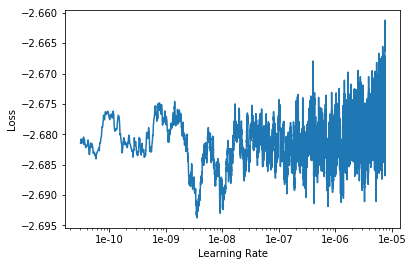

In [37]:
'plot'
l.recorder.plot()

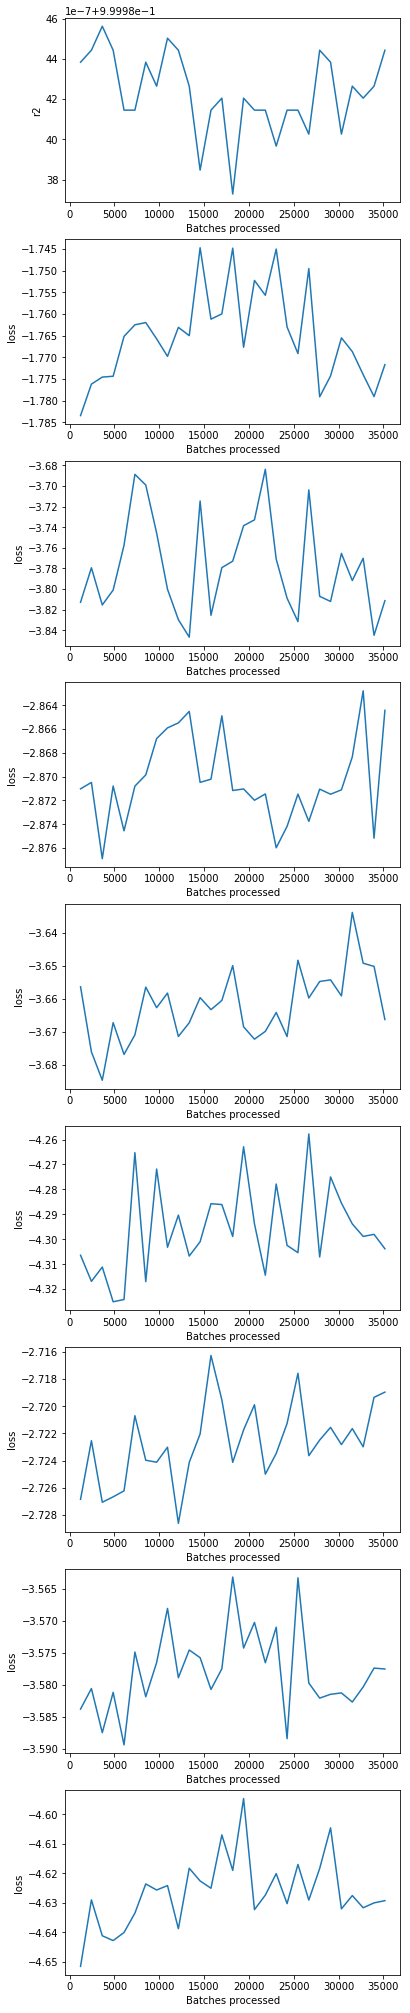

In [38]:
l.recorder.plot_metrics()

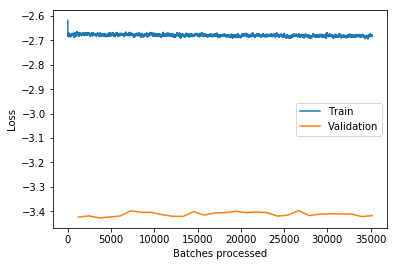

In [39]:
l.recorder.plot_losses()

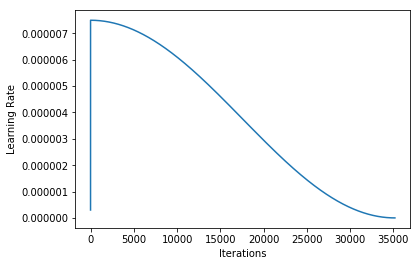

In [40]:
l.recorder.plot_lr()

In [41]:
predict_and_save(l.model, test)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [42]:
pd.read_csv("submission.csv").shape

(2505542, 2)

In [43]:
!ls

__notebook__.ipynb  __output__.json  history.csv  models  submission.csv


In [44]:
from IPython.display import FileLink
FileLink("submission.csv")

/kaggle/working/submission.csv

In [45]:
import zipfile
 
my_zipfile = zipfile.ZipFile("sub.zip", mode='w', compression=zipfile.ZIP_DEFLATED)
my_zipfile.write("submission.csv")
my_zipfile.close()
FileLink("sub.zip")

/kaggle/working/sub.zip

In [46]:
!ls -alh

total 92M
drwxr-xr-x 3 root root 4.0K Aug 26 02:18 .
drwxr-xr-x 6 root root 4.0K Aug 25 18:09 ..
-rw-r--r-- 1 root root  23K Aug 25 18:09 __notebook__.ipynb
-rw-r--r-- 1 root root  624 Aug 26 02:18 __output__.json
-rw-r--r-- 1 root root 3.5K Aug 26 02:11 history.csv
drwxr-xr-x 2 root root 4.0K Aug 25 18:09 models
-rw-r--r-- 1 root root  27M Aug 26 02:18 sub.zip
-rw-r--r-- 1 root root  65M Aug 26 02:18 submission.csv


In [47]:
l.save('model')